## Denoiser evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from sklearn import metrics

from yass.augment import make
from pathlib import Path
from statsmodels.tsa.stattools import acf
import sklearn_evaluation.plot as skplot

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util as augment_util
from yass.augment import noise as noise_utils
from yass.batch import RecordingsReader
from yass.augment.util import amplitudes

import seaborn as sns
import pandas as pd
from dstools import plot
from keras.models import load_model

Using TensorFlow backend.


In [3]:
from os import path

path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [4]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

## Load model

In [171]:
model = load_model('/tmp/denoiser.h5')

In [172]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 20, 32)            5120      
_________________________________________________________________
lstm_15 (LSTM)               (None, 20, 16)            3136      
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 9,065
Trainable params: 9,065
Non-trainable params: 0
_________________________________________________________________


## Evaluation on test set

## Template loading

In [8]:
uncropped = np.load(Path('~', 'data', 'cat', 'templates-jul27-only-good.npy').expanduser())

In [83]:
templates_raw = TemplatesProcessor(uncropped).crop_spatially(CONFIG.neigh_channels, CONFIG.channel_index[:, :7]).values
templates_raw = templates_raw[np.argsort(augment_util.amplitudes(templates_raw))]
templates_raw.shape

(240, 61, 7)

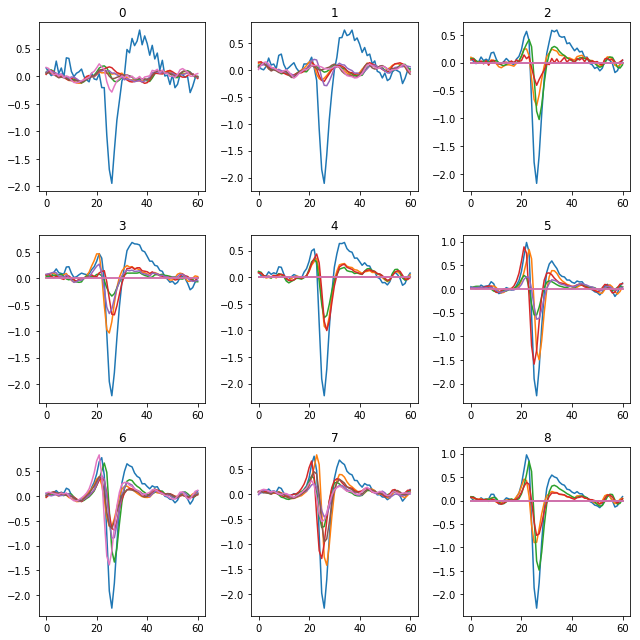

In [84]:
# should i use this small templates?
plot.grid_from_array(templates_raw, axis=0, elements=range(9), auto_figsize=3)

In [86]:
from yass.geometry import make_channel_index

ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]

(spatial_sig,
 temporal_sig) = noise_utils.noise_cov(rec, 61, 61)

spatial_sig.shape, temporal_sig.shape

((7, 7), (61, 61))

In [89]:
# add noise
templates_noisy, _ = augment_util.add_noise(templates_raw,
                                            spatial_sig, temporal_sig,
                                            reject_cancelling_noise=True)
print(templates_noisy.shape)

(165, 61, 7)


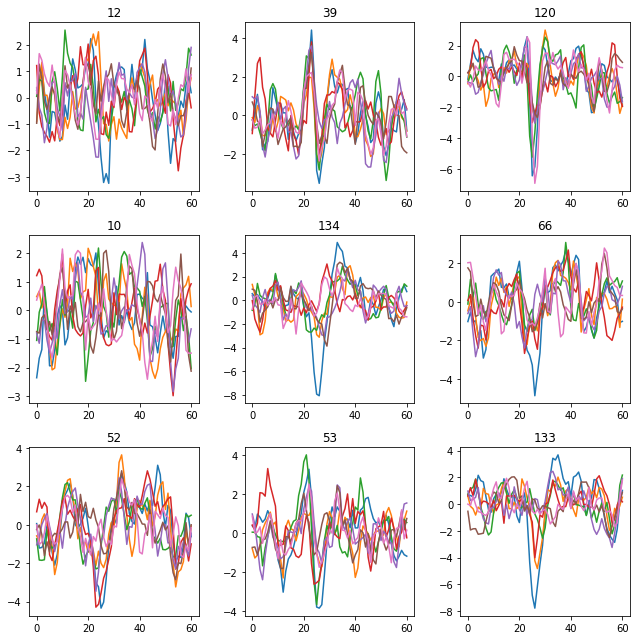

In [91]:
plot.grid_from_array(templates_noisy, axis=0, elements=9, auto_figsize=3)

## Denoise templates

## Denoise the same input many times

## Generate testing data

In [92]:
min_amp = 5
max_amp = 10
n_clean_per_template = 20

In [93]:
dataset = Dataset.make(units_per_bin=0.5,
                       include_clean_data=True,
                       templates=templates_raw,
                       min_amplitude=min_amp,
                       max_amplitude=max_amp,
                       n_per_template=n_clean_per_template,
                       spatial_sig=spatial_sig,
                       temporal_sig=temporal_sig,
                       make_from_templates=True,
                       make_spatially_misaligned=False,
                       make_temporally_misaligned=False,
                       make_collided=False,
                       make_noise=True,
                       add_noise_kwargs={'reject_cancelling_noise': True})

In [94]:
dataset.stats

{'from templates': 2761, 'noise': 4800}

In [95]:
def sort_data(data):
    amps = amplitudes(data)
    print(amps.min(), amps.max())
    return data[np.argsort(amps)]

In [96]:
IDX = 40
REPEATS = 20
to_denoise = dataset.get_kind('from templates').data_clean[[IDX], :, :]
print(to_denoise.shape)
to_denoise_repeated = np.repeat(to_denoise, repeats=REPEATS, axis=0)
print(to_denoise_repeated.shape)
to_denoise_repeated, _ = augment_util.add_noise(to_denoise_repeated, spatial_sig, temporal_sig)
print(to_denoise_repeated.shape)

(1, 61, 7)
(20, 61, 7)
(20, 61, 7)


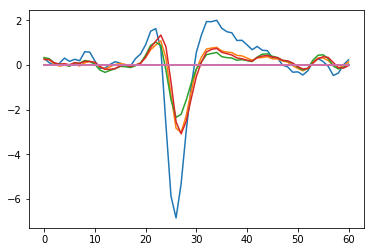

In [97]:
middle = 30
lookback = 10
lookforward = 0
# middle-half_window:middle+half_window+1
truth = dataset.data_clean[IDX]
_ = plt.plot(truth)

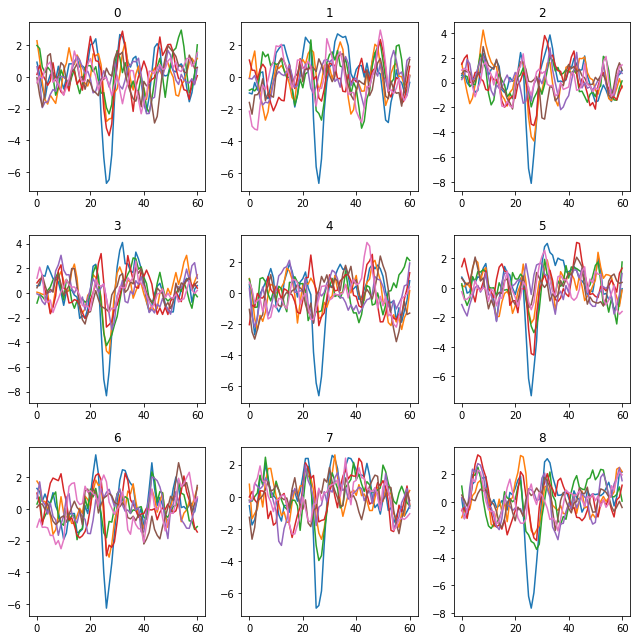

In [98]:
plot.grid_from_array(to_denoise_repeated, axis=0, auto_figsize=3, elements=range(9))

In [99]:
to_denoise_repeated.shape

(20, 61, 7)

In [100]:
def make_data(data, lookback=10, step=1, delay=0):
    length = data.shape[1]
    delay = 0
    i = 0
    max_i = length - lookback - delay - 1
    
    n_per_sample = int((length - lookback - delay) / step)
    n_batch = data.shape[0]
    n_total = n_batch * n_per_sample

    out_data = np.zeros((n_total, lookback, data.shape[2]))
    out_objective = np.zeros(n_total)

    for i in range(0, max_i + 1, step):
        window = slice(i, lookback + i)
        objective = lookback + delay + i

        out_data[i*n_batch:n_batch*(i+1), :, :] = data[:, window, :]
        out_objective[i*n_batch:n_batch*(i+1)] = data[:, objective, 0]
    
    return out_data, out_objective

In [112]:
to_denoise_repeated[1].shape

(61, 7)

In [174]:
x, y = make_data(to_denoise_repeated[0][np.newaxis, :, :], lookback=20)

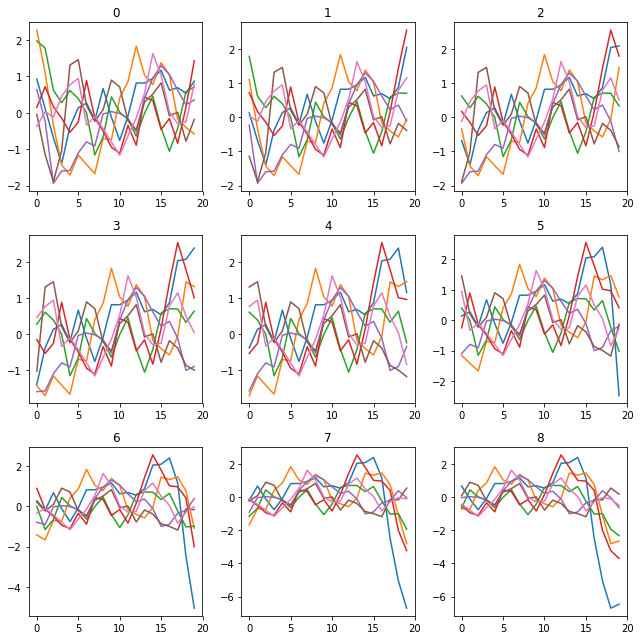

In [175]:
plot.grid_from_array(x, axis=0, auto_figsize=3, elements=range(9))

In [176]:
model.input_shape

(None, 20, 7)

In [177]:
y_pred = model.predict(x)

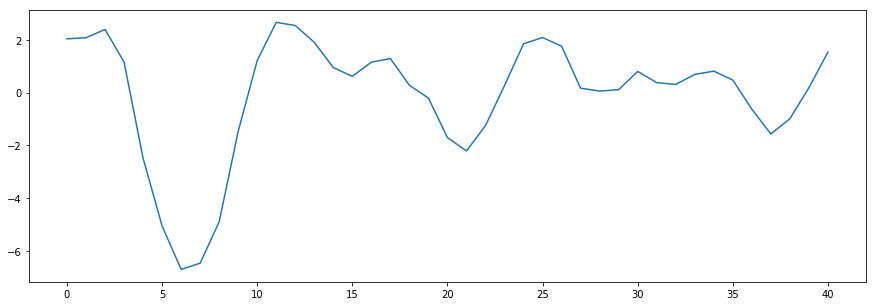

In [178]:
plt.plot(y)

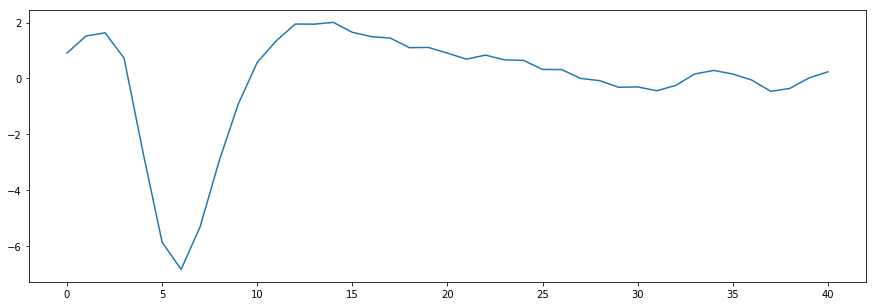

In [181]:
plt.plot(truth[20:, 0])

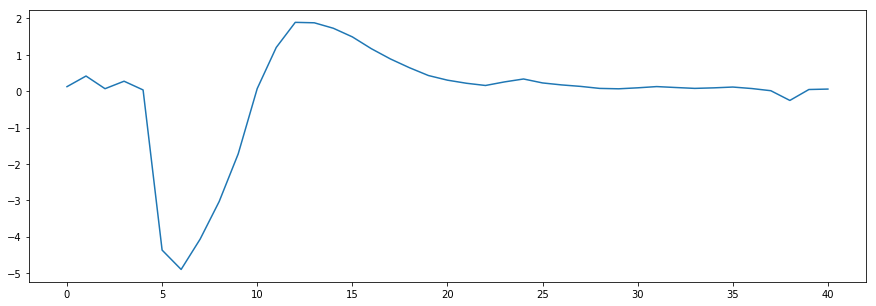

In [180]:
plt.plot(y_pred)

## Denoising recordings

In [182]:
plt.rcParams['figure.figsize'] = (15, 5)

In [183]:
rec.shape

(6000000, 7)

In [208]:
x, y = make_data(rec[np.newaxis, 100100:100300, :], lookback=20)

In [209]:
x.shape, y.shape

((180, 20, 7), (180,))

In [210]:
y_pred = model.predict(x)

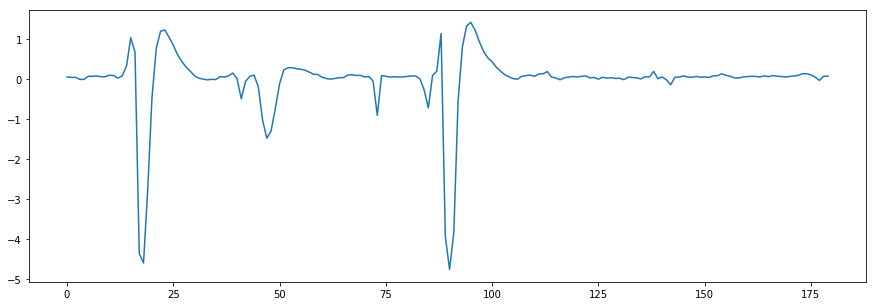

In [211]:
plt.plot(y_pred)

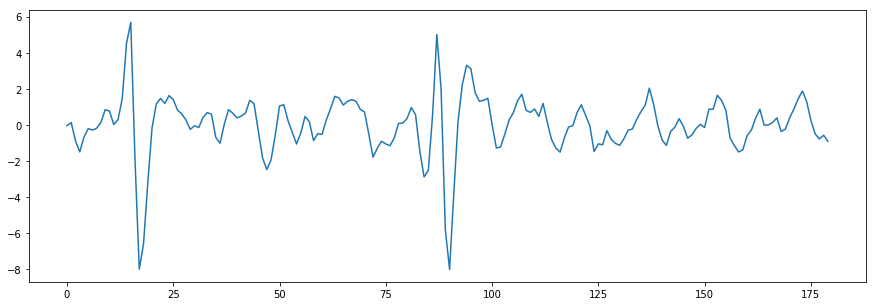

In [212]:
plt.plot(y)